

**This notebook covers:**

    1.Data Loading & Preprocessing: Loading economic_indicators_1000.csv .
    2.Model Training: Training Linear Regression and Decision Tree models.
    3:Evaluation Comparing models using MSE and R2 Score.
    4.Selection: Picking the best model.
    5.Visualization: Visualizing performance and predictions.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Set random seed for reproducibility
np.random.seed(42)

**Importing the dataset**

In [32]:
df = pd.read_csv('economic_indicator.csv')
st.subheader("Historical Economic Data")
st.dataframe(df)

# View the dataset
df.head()

,Date,GDP_Growth (%),Inflation_Rate (%),Unemployment_Rate (%),Interest_Rate (%),Exchange_Rate (TZS),Stock_Index
0,3/31/1990,4.15,15.09,10.03,31.67,1114,851.78
1,6/30/1990,4.09,15.63,10.09,31.67,1224,983.63
2,9/30/1990,4.45,14.56,10.27,31.67,1184,950.78
3,12/31/1990,4.82,15.36,9.34,31.67,1144,856.77
4,3/31/1991,4.40,15.26,9.99,31.67,1240,804.71


**Identifying and Handling Missing Values**

In [33]:
# Check for missing values
print(df.isnull().sum())

Date                     0
GDP_Growth (%)           0
Inflation_Rate (%)       0
Unemployment_Rate (%)    0
Interest_Rate (%)        0
Exchange_Rate (TZS)      0
Stock_Index              0
dtype: int64


In [34]:
# Convert Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

#clean column name
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("(", "")
df.columns = df.columns.str.replace(")", "")

# Save Date for later visualization
dates = df['Date']

# Drop Date for training
df = df.drop(columns=['Date'])

print(df.columns)

#features selection
feature_cols = ['GDP_Growth_%',
                'Inflation_Rate_%',
                'Unemployment_Rate_%',
                'Interest_Rate_%',
                'Exchange_Rate_TZS']

X = df[feature_cols]
y = df['Stock_Index']

#Train-Test split
# Time-based split
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Index(['GDP_Growth_%', 'Inflation_Rate_%', 'Unemployment_Rate_%',
       'Interest_Rate_%', 'Exchange_Rate_TZS', 'Stock_Index'],
      dtype='object')
Training shape: (112, 5)
Testing shape: (28, 5)


**Train Models**

In [37]:
#we train two models Linear Regression and Decision Tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Create models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)

# Train
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)


DecisionTreeRegressor(random_state=42)

**Models Evaluation**

In [49]:
from sklearn.metrics import mean_absolute_error, r2_score

# Predictions
lr_pred = lr.predict(X_test)
dt_pred = dt.predict(X_test)

# Evaluate Linear Regression
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

# Evaluate Decision Tree
dt_mse = mean_squared_error(y_test, dt_pred)
dt_r2 = r2_score(y_test, dt_pred)

# Results Table
# -----------------------------
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree'],
    'MSE': [lr_mse, dt_mse],
    'R2 Score': [lr_r2, dt_r2]
})

print("\nModel Comparison:")
print(results)

print("\nLinear Regression MSE:", lr_mse)
print("Linear Regression R2:", lr_r2)

print("\nDecision Tree MSE:", dt_mse)
print("Decision Tree R2:", dt_r2)



Model Comparison:
               Model           MSE  R2 Score
0  Linear Regression  11874.990773  0.700618
1      Decision Tree  31084.093800  0.216336

Linear Regression MSE: 11874.990772722726
Linear Regression R2: 0.7006183061424941

Decision Tree MSE: 31084.09380000001
Decision Tree R2: 0.21633550442448912


**Select best Models**

In [51]:
# Rank Models
# -----------------------------
# Rank MSE (lower is better)
results['MSE_Rank'] = results['MSE'].rank(ascending=True)

# Rank R2 (higher is better)
results['R2_Rank'] = results['R2 Score'].rank(ascending=False)

# Combine ranks
results['Total_Rank'] = results['MSE_Rank'] + results['R2_Rank']

print("\nRanked Model Comparison:")
print(results)

# -----------------------------
# Select Best Model
# -----------------------------
best_model_name = results.loc[results['Total_Rank'].idxmin(), 'Model']

print(f"\nBest Model (Based on MSE & R2): {best_model_name}")

# -----------------------------
# Assign Best Model
# -----------------------------
if best_model_name == 'Linear Regression':
    final_model = lr
else:
    final_model = dt

# -----------------------------
# Save Best Model
# -----------------------------
import joblib
joblib.dump(final_model, 'model.pkl')

print(f"Saved {best_model_name} as 'model.pkl'")



Ranked Model Comparison:
               Model           MSE  R2 Score  MSE_Rank  R2_Rank  Total_Rank
0  Linear Regression  11874.990773  0.700618       1.0      1.0         2.0
1      Decision Tree  31084.093800  0.216336       2.0      2.0         4.0

Best Model (Based on MSE & R2): Linear Regression
Saved Linear Regression as 'model.pkl'


**Visualization**

In [45]:
#Saving Best Model
import joblib

joblib.dump(lr, "model.pkl")


['model.pkl']

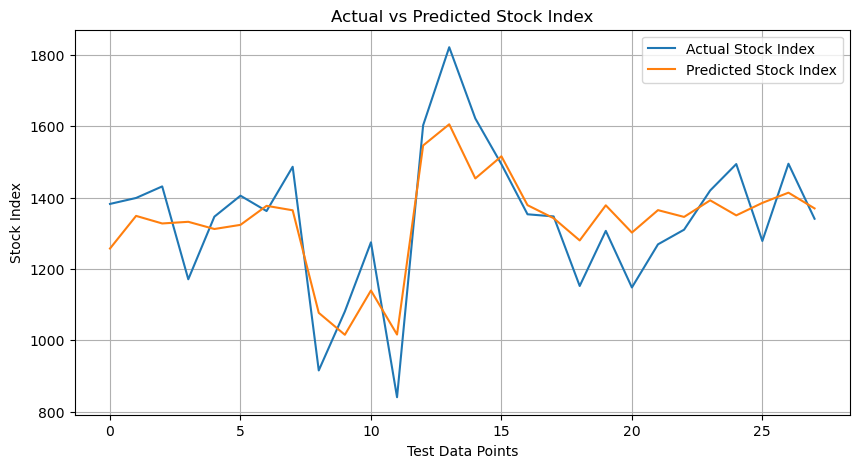

In [52]:
import matplotlib.pyplot as plt

# Use best model predictions
best_pred = final_model.predict(X_test)

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual Stock Index")
plt.plot(best_pred, label="Predicted Stock Index")
plt.title("Actual vs Predicted Stock Index")
plt.xlabel("Test Data Points")
plt.ylabel("Stock Index")
plt.legend()
plt.grid(True)
plt.show()


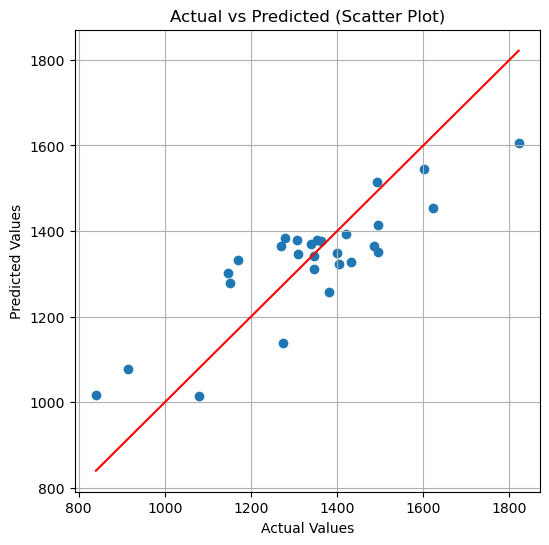

In [53]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted (Scatter Plot)")
plt.grid(True)
plt.show()


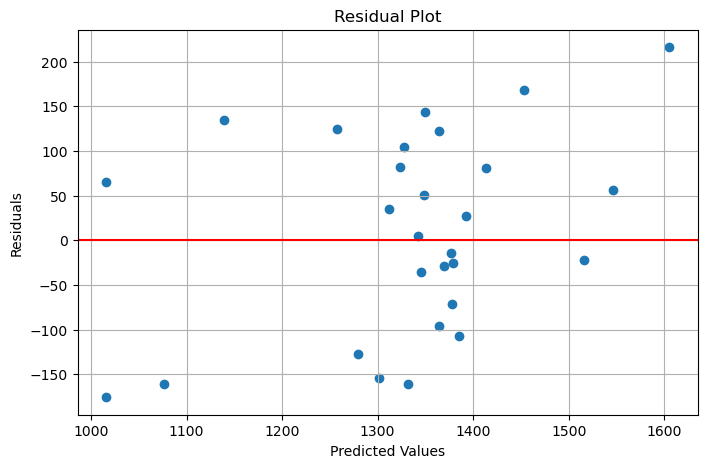

In [54]:
residuals = y_test - best_pred

plt.figure(figsize=(8,5))
plt.scatter(best_pred, residuals)
plt.axhline(y=0, color='red')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()


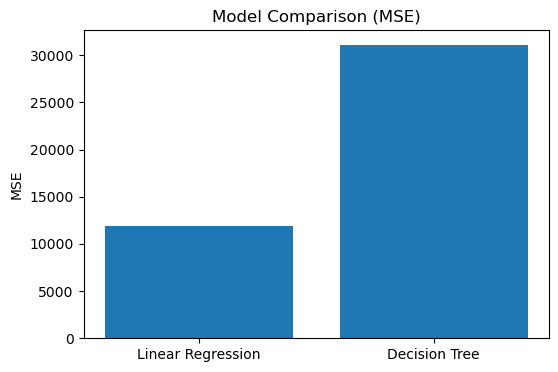

In [55]:
plt.figure(figsize=(6,4))
plt.bar(results['Model'], results['MSE'])
plt.title("Model Comparison (MSE)")
plt.ylabel("MSE")
plt.show()
